# Car Price prediction

**Цель проекта** - предсказать цену автомобиля

**Задачи**:
 - Подготовить набор данных для обучения модели
 - Потренировать работу с pandas на реальных данных
 - Попрактиковаться в построении различных моделий:
     - на основе градиентного бустинга с помощью CatBoost
     - на основе нейронных сетей
     - multi-input нейронную сеть для анализа табличных данных и текста одновременно
     - multi-input сеть для анализа табличных данных, текста и обработку изображений одновременно
     - ансамблирование градиентного бустинга и нейронной сети

**Общий план проекта**:
* ***Часть первая (текущая)*** - *[SF Car Price 2] Emelyanov p.1 (EDA+CatBoost+NN1)*
* Построим "наивную" модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Построим первую модель на основе градиентного бустинга с помощью CatBoost
* Построим вторую модель на основе нейронных сетей и сравним результаты
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)
* ***Часть вторая*** - *[SF Car Price 2] Emelyanov p.2 (NN1+NLP+CV)*
* Возьмем уже обработанные данные из первой части
* Построим multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга (из первой части) и multi-input нейронной сети (усреднение их предсказаний)




# Часть первая

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 1. Import

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import math
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from itertools import combinations
from scipy.stats import ttest_ind

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Уберем Warnings из отображения
import warnings; warnings.simplefilter('ignore')

# Поправим отображение дасетов
pd.set_option('display.max_columns', None)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
!pip freeze > requirements.txt

**МЕТРИКА**

Определим метрику для проверки моделей - MAPE (Mean Percentage Absolute Error, расшифровывается выражение как средняя абсолютная ошибка в процентах).

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 2. Setup

In [7]:
VERSION    = 19 # версия запуска для сохранения ответов

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

DATA_DIR   = '../input/sf-dst-car-price-prediction-part2/'
FILE_TRAIN = 'train.csv'
FILE_TEST  = 'test.csv'
FILE_SUB   =  'sample_submission.csv'

VAL_SIZE   = 0.15   # 15% для разделения выборки на обучающую и тестовую

# 3. Data

In [8]:
def load_data_frames():
    # Выгружает три датасета
    train = pd.read_csv(DATA_DIR + FILE_TRAIN)
    test = pd.read_csv(DATA_DIR + FILE_TEST)
    sample_submission = pd.read_csv(DATA_DIR + FILE_SUB)
    
    return train, test, sample_submission

In [9]:
train, test, sample_submission = load_data_frames()

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
train.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4280,седан,BMW,серый,ID: 38742\n«МБ Измайлово» – официальный диле...,2.0 LTR,136 N12,бензин,241251,2008,3ER,318i 2.0 AT (136 л.с.),4,539000.0,2011,1099684586,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5975,седан,AUDI,коричневый,Продаю свой авто в связи с крайне редким испол...,1.8 LTR,120 N12,бензин,55000,2011,A4,1.8 CVT (120 л.с.),4,950000.0,2014,1093102394,SEDAN VARIATOR 1.8,вариатор,2 владельца,NaN,Оригинал,передний,Левый


In [11]:
test.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1653,седан,BMW,серебристый,"Не бита, не крашена . \nАвтомобиль в полном по...",3.0 LTR,258 N12,бензин,90586,2005,3ER,330xi 3.0 AT (258 л.с.) 4WD,4,2006,1086926749,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,1 год и 7 месяцев,Оригинал,полный,Левый
1455,внедорожник 5 дв.,AUDI,красный,"Я владелец, показываю тоже сам. \n\nДелать нич...",2.0 LTR,211 N12,бензин,133882,2008,Q5,2.0 AMT (211 л.с.) 4WD,5,2011,1100134416,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,3 или более,3 года,Оригинал,полный,Левый


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

Форматы данных в обучающем и тестовом датасетах не отлючаются - можно будет их объединить без дополнительной обработки. Для удобства переименуем поля с русского языка на английский.

In [14]:
train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [15]:
def rename_columns_train(train: pd.DataFrame) -> None: 
    # Переименуем названия признаков в train датасете
    train.columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'price', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]
    
def rename_columns_test(test: pd.DataFrame) -> None: 
    # Переименуем названия признаков в test датасете
    test.columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]   

In [16]:
def concatenate_data_frames(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
    columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]
    
    df_train = train[columns]
    df_test = test[columns]

    df_train['price'] = train['price']  # Целевая переменная трейна
    df_test['price'] = 0                # Целевой переменной теста нет, поэтому занулим пока
    
    df_train['sample'] = 1 # помечаем где у нас трейн
    df_test['sample'] = 0  # помечаем где у нас тест

    return df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [17]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

In [18]:
data.sample(5)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,name,number_of_doors,production_date,sell_id,vehicle_configuration,vehicle_transmission,owners,ownership,pts,drive_type,wheel,price,sample
8166,седан,BMW,чёрный,"В отличном состоянии, обслуживался у оф дилера...",3.0 LTR,326 N12,бензин,91000,2015,7ER,740Li xDrive 3.0 AT (326 л.с.) 4WD,4,2017,1099912984,SEDAN AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,3599999.0,1
5457,внедорожник 5 дв.,MERCEDES,белый,"[Smart]\nОригинал ПТС, По факту один владелец,...",3.0 LTR,333 N12,бензин,72304,2015,GLE_KLASSE_COUPE,400 3.0 AT (333 л.с.) 4WD,5,2016,1100114232,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,3648000.0,1
7112,внедорожник 5 дв.,BMW,синий,Автомобиль в идеальном состояние. \nВложений н...,3.0 LTR,306 N12,дизель,112000,2012,X6,40d 3.0d AT (306 л.с.) 4WD,5,2013,1098723744,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2 владельца,1 год и 9 месяцев,Оригинал,полный,Левый,2000000.0,1
2127,седан,MERCEDES,чёрный,Как из салона\nПродажа с юридического лица,2.0 LTR,194 N12,дизель,25000,2016,E_KLASSE,220 d 2.0d AT (194 л.с.) 4WD,4,2018,1100168826,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,2750000.0,1
1034,внедорожник 5 дв.,AUDI,белый,\nВладею авто с 2015 года. \nЯ вторая владелец...,2.0 LTR,211 N12,бензин,195000,2008,Q5,8tiptronic 2.0 AT (211 л.с.) 4WD,5,2012,1099830702,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0.0,0


# 4. Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [19]:
# split данных
data_train, data_test = train_test_split(data.query('sample == 1'), test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [20]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'production_date']]).iterrows():
    query = f"model_info == '{row[0]}' and production_date == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Создадим более продвинутые модели. Для этого необходимо дополнительно обработать данные.

# 5. Cleaning and Prepping Data

## Определим вспомогательные функции

In [21]:
def data_full_info(data, full=True, short=False) -> None:
    '''Функция для вывода общей информации по датасету.
    data - набор исходных данных
    full - флаг вывода информации для количественных признаков
    short - флаг вывода информации из первых трех строк датасета
    
    Функция для выводит общую информацию по датасету.
    
    Если установлен флаг short, то отобразить первые три строки из датасета.
    В ином случае - не отображать.
    
    
    Если установлен флаг full, то отобразить информацию для количественных признаков.
    В ином случае - не отображать.
    '''
        
    list_of_names = list(data.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = data.dtypes
    temp_dict['# значений'] = data.describe(include='all').loc['count'].astype(int)
    temp_dict['# пропусков(NaN)'] = data.isnull().sum().values 
    temp_dict['# уникальных'] = data.nunique().values
    
    if not short:
        temp_dict['в первой строке'] =data.loc[0].values
        temp_dict['во второй строке'] = data.loc[1].values
        temp_dict['в третьей строке'] = data.loc[2].values
        
    if full :
        temp_dict['минимум'] = data.describe(include='all').loc['min']
        temp_dict['среднее'] = data.describe(include='all').loc['mean']
        temp_dict['макс'] = data.describe(include='all').loc['max']
        temp_dict['медиана'] = data.describe(include='all').loc['50%']
        
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [22]:
def column_info(data: pd.DataFrame, column: str) -> None:
    '''Функция для вывода информации для номинативных признаков.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений номинативного признака и выводит их в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Тип данных: ', data[column].dtype)
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
      
    display(pd.DataFrame(data[column].value_counts()).head(10))
    

def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений и значениий ограниченных границами выбросов IQR.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR

    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    plt.rcParams['figure.figsize'] = (10,7)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=20,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=20, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();

In [23]:
def plot_column_info_log(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений, boxplot исходных значений, гистограмму логарифма исходных значений 
    и boxplot для них.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'
    
    outliers_num = data.query(f'{column} < {lower_limt} or {column} > {upper_limit}').shape[0]
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    print('Количество выбросов:', outliers_num)
    
    plt.rcParams['figure.figsize'] = (12,4)
    
    ser_iqr = data[column].loc[data[column].between(lower_limt, upper_limit)]
    ser_act = data[column]
    ser_log = data[column].apply(lambda x: math.log(x + 1))
    
    fig = plt.figure()
    st = fig.suptitle(f'Гистограммы и box-plot для признака \'{column}\' и log(\'{column}\')', fontsize='x-large')
    
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)
    
    ax_1.hist(ser_act, bins=15)
    ax_1.set_title(f'\'{column}\'', loc = 'right', fontsize=10)
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
    ax_2.boxplot(ser_act)
    ax_2.set_title(f'boxplot of \'{column}\'', loc = 'left', fontsize=10)
    ax_2.spines['top'].set_visible(False)
    ax_2.spines['right'].set_visible(False)
    ax_2.spines['bottom'].set_visible(False)
    ax_2.spines['left'].set_visible(False)
    
    ax_3.hist(ser_log, bins=15)
    ax_3.set_title(f'log(\'{column}\')', loc = 'right', fontsize=10)
    ax_3.spines['top'].set_visible(False)
    ax_3.spines['right'].set_visible(False)
    
    ax_4.boxplot(ser_log)
    ax_4.set_title(f'boxplot of log(\'{column}\')', loc = 'left', fontsize=10)
    ax_4.spines['top'].set_visible(False)
    ax_4.spines['right'].set_visible(False)
    ax_4.spines['bottom'].set_visible(False)
    ax_4.spines['left'].set_visible(False)
    
    
    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.85)
    
    plt.legend()
    plt.show();

In [24]:
def replace_nan(data_in: pd.DataFrame, column: str, typ: str, new_value='') -> pd.DataFrame:
    '''Функция возвращает датасет, в котором произведена замена пустых значений признака и добавлен новый
    признак, в котором сохраняется информаця о том, в какой строке было пустое значение
    data_in - набор исходных данных
    column - наименование признака
    typ - тип замены, может принимать значения: 'mode', 'median', 'mean', 'new_value'
    
    Создается новый признак с наименованием (column)_isnan, в котором сохраняется информаця 
    о том, в какой строке пустое значение признака (column)
    В зависимости от типа замены (typ) функция определяет значение, 
    на которое будет производится замена.
    Все значения признака (column) в наборе данных (data_in) заменяются на вычисленное значение.
    Функция возращает откорректированный набор данных, изменений в исходном наборе нет.
    
    '''
    
    data = data_in.copy()
    
    print(f'В новый признак \'{column}_isnan\' охраняем информацию, в каком наблюдении указано NaN')
    data.loc[:, column + '_isnan'] = pd.isna(data[column]).astype('uint8')
    
    if typ == 'mode':
        m = data.loc[:, column].mode()[0]
        s = 'самым распространенным значением '
    elif typ == 'median':
        m = data.loc[:, column].median()
        s = 'медианой'
    elif typ == 'mean':
        m = data.loc[:, column].mean()
        s = 'средневзвешенным значением'
    elif typ == 'new_value':
        m = new_value
        s = 'указанным значением'
    else:
        return None
    
    print(f'Заполним пустые значения признака {column} {s} {m}')
    data.loc[:, column] = data[column].fillna(m)
    
    return data

In [25]:
def get_stat_dif(data: pd.DataFrame, column: str, target: str) -> bool:
    '''Функция определяет, есть ли статистически значимые различия для признака.
    data - набор исходных данных
    column - наименование признака
    target - наименование целевого признака
    
    Функция проверяет, есть ли статистическая разница в распределении целевого признака (target)
    по номинативному признаку (column) в наборе данных (data). 
    Проверка осуществляется с помощью теста Стьюдента. 
    Проверяется нулевая гипотеза о том, что распределения целевого признака (target)
    по различным парам значений номинативного признака (column) неразличимы.
    Пары определяются из различных комбинаций n самых часто встречающихся занчений признака (column).
    Если различия найдены, то информация об этом выводится в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    cols = data.loc[:, column].value_counts().index[:n]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], target], 
                     data.loc[data.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для признака', column)
            return True
    
    return False

In [26]:
# вспомогательная функция для обработки признака engineDisplacement

def search_engine_displacement(text: str) -> float:
    pattern = '\d\.\d'
    match = re.findall(pattern, str(text))
    n = len(match)
    
    if n == 2:
        return float(match[1])
    elif n == 1:
        return float(match[0])
    else:
        return .0

In [27]:
# вспомогательная функция для обработки признака color

def color_is_popular(text: str) -> int:
    if text in ['чёрный']:
        return 4
    elif text in ['белый']:
        return 3
    elif text in ['серый', 'синий']:
        return 2
    elif text in ['серебристый', 'коричневый', 'красный']:
        return 1
    else:
        return 0

## EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [28]:
# Выведем общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,body_type,object,8353,0,17,NaN,NaN,NaN,NaN
1,brand,object,8353,0,3,NaN,NaN,NaN,NaN
2,color,object,8353,0,16,NaN,NaN,NaN,NaN
3,description,object,8353,0,7654,NaN,NaN,NaN,NaN
4,engine_displacement,object,8353,0,48,NaN,NaN,NaN,NaN
5,engine_power,object,8353,0,154,NaN,NaN,NaN,NaN
6,fuel_type,object,8353,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,8353,0,3507,1,120363,1e+06,110384
8,model_date,int64,8353,0,43,1971,2010.1,2019,2011
9,model_info,object,8353,0,122,NaN,NaN,NaN,NaN


In [29]:
# Заведем списки под разные  типы признаков

# Бинарные признаки 
bin_cols = []

# Категориальные признаки
cat_cols = []

# Колличественные признаки 
num_cols = []

# Лишние признаки
del_cols = []

# Признаки с дополнительной информацией, которая требует отдельной обработки
info_cols = []

# целевые признаки
target_cols = []

Посмотрим признаки, в которых есть пропуски - 'owners' и 'ownership'

Признак **'owners'**

In [30]:
data.query('owners != owners')

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,name,number_of_doors,production_date,sell_id,vehicle_configuration,vehicle_transmission,owners,ownership,pts,drive_type,wheel,price,sample
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,4.2 AT (360 л.с.) 4WD,4,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,600000.0,1


In [31]:
# Вынесем в блок предобработки

# Заполним пропуски в поле owners самым распространенным значением
data = replace_nan(data, 'owners', 'mode')

В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners самым распространенным значением  3 или более


Признак **'ownership'**

In [32]:
# Доля пустых значений в поле ownership
column_name = 'ownership'
print(f"Доля пустых значений в поле {column_name}: { (data[column_name].isna().sum() / data[column_name].shape[0]) * 100:0.2f}%")

Доля пустых значений в поле ownership: 64.86%


In [33]:
# Выносим в блок предобработки

# Доля пустых значений в поле ownership очень большая, мы не можем полагаться на значения данного поля - удалим
data.drop(['ownership'], axis=1, inplace=True)

In [34]:
# Еще раз посмотрим общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,body_type,object,8353,0,17,NaN,NaN,NaN,NaN
1,brand,object,8353,0,3,NaN,NaN,NaN,NaN
2,color,object,8353,0,16,NaN,NaN,NaN,NaN
3,description,object,8353,0,7654,NaN,NaN,NaN,NaN
4,engine_displacement,object,8353,0,48,NaN,NaN,NaN,NaN
5,engine_power,object,8353,0,154,NaN,NaN,NaN,NaN
6,fuel_type,object,8353,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,8353,0,3507,1,120363,1e+06,110384
8,model_date,int64,8353,0,43,1971,2010.1,2019,2011
9,model_info,object,8353,0,122,NaN,NaN,NaN,NaN


Пройдем по всем признакам, посмотрим, необходима ли дополнительная обработка для них.

Признак **'body_type'**

In [35]:
column_info(data, 'body_type')

Проведем анализ для переменной body_type
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 11
Уникальных значений: 17


,body_type
седан,3541
внедорожник 5 дв.,2896
купе,543
хэтчбек 5 дв.,364
лифтбек,299
универсал 5 дв.,196
минивэн,178
купе-хардтоп,111
родстер,88
хэтчбек 3 дв.,57


In [36]:
# посмотрим, есть ли проблемы со значениями
data['body_type'].unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

In [37]:
# можно оставить только внедорожник, седан, лифтбек и т.д. без доп.информации
data.loc[:, 'body_type'] = data['body_type'].apply(lambda x: x.split(' ')[0].lower())

In [38]:
column_info(data, 'body_type')

Проведем анализ для переменной body_type
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 10
Уникальных значений: 13


,body_type
седан,3542
внедорожник,2905
купе,543
хэтчбек,421
лифтбек,299
универсал,196
минивэн,178
купе-хардтоп,111
родстер,88
кабриолет,54


Пока оставим данный признак так.

Признак **'brand'**

In [39]:
column_info(data, 'brand')

Проведем анализ для переменной brand
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,brand
BMW,3535
MERCEDES,2846
AUDI,1972


Все хорошо. Оставляем признак как есть.

Признак **'color'**

In [40]:
column_info(data, 'color')

Проведем анализ для переменной color
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 15
Уникальных значений: 16


,color
чёрный,3468
белый,1607
серый,925
синий,863
серебристый,420
коричневый,386
красный,266
голубой,91
зелёный,86
бежевый,85


In [41]:
# посмотрим, есть ли проблемы со значениями
data['color'].unique()

array(['чёрный', 'белый', 'пурпурный', 'синий', 'коричневый', 'серый',
       'зелёный', 'серебристый', 'красный', 'оранжевый', 'голубой',
       'фиолетовый', 'бежевый', 'жёлтый', 'золотистый', 'розовый'],
      dtype=object)

In [42]:
# Выносим в блок предобработки

# Добавим новый признак - степень популятности цвета    
data.loc[:, 'color_is_popular'] = data['color'].apply(color_is_popular)

Все хорошо. Оставляем признак как есть.

Признак **'description'** пока пропустим, его будет обрабатывать нейросеть.

Признак **'engine_displacement'**

In [43]:
column_info(data, 'engine_displacement')

Проведем анализ для переменной engine_displacement
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 35
Уникальных значений: 48


,engine_displacement
2.0 LTR,2430
3.0 LTR,2349
1.8 LTR,411
1.6 LTR,410
4.4 LTR,329
5.5 LTR,268
3.5 LTR,250
2.5 LTR,248
2.1 LTR,221
4.0 LTR,153


In [44]:
# посмотрим, есть ли проблемы со значениями
data['engine_displacement'].unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

Обработаем значения этого признака - вычленим только цисловое значение.

In [45]:
# Вынесем в блок предобработки

# вынесем существенную информацию и преобразуем значения в численный формат
data.loc[:, 'engine_displacement'] = data['engine_displacement'].apply(search_engine_displacement)

In [46]:
# посмотрим, есть ли проблемы со значениями
data['engine_displacement'].unique()

array([3. , 2.5, 2. , 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4. , 1.5, 2.4,
       1.4, 2.1, 5.2, 4.4, 2.8, 4.2, 3.2, 6. , 3.7, 5. , 1.2, 3.6, 2.3,
       6.2, 1.7, 1.3, 5.4, 3.1, 2.6, 3.8, 4.1, 2.9, 6.6, 5.9, 0. , 2.7,
       0.7, 1.9, 4.3, 5.8, 4.9, 3.4, 6.3, 5.6, 4.6])

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,
Границы значений: [0.0, 6.6],
Границы выбросов: [0.5, 4.5].
Есть выбросы.
Количество выбросов: 699


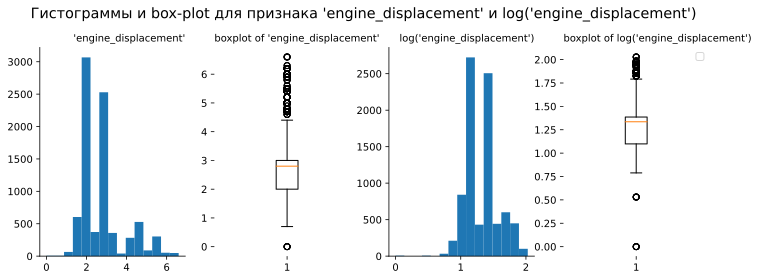

In [47]:
plot_column_info_log(data, 'engine_displacement')

Все хорошо. Оставляем признак как есть.

Признак **'engine_power'**

In [48]:
column_info(data, 'engine_power')

Проведем анализ для переменной engine_power
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 92
Уникальных значений: 154


,engine_power
184 N12,759
249 N12,655
190 N12,420
245 N12,355
306 N12,344
211 N12,310
150 N12,278
170 N12,274
218 N12,233
156 N12,223


In [49]:
# посмотрим, есть ли проблемы со значениями
data['engine_power'].unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

Обработаем значения этого признака - вычленим только цисловое значение.

In [50]:
# Вынесем в блок предобработки

# Поле engine_power в test представлено в виде "306 N12", нам надо только число Л.С.
data.loc[:, 'engine_power'] = data['engine_power'].apply(lambda x: int(x.split(' ')[0]))

In [51]:
# посмотрим, есть ли проблемы со значениями
data['engine_power'].unique()

array([220, 313, 218, 136, 190, 340, 245, 316, 170, 160, 231, 388, 180,
       367, 115, 184, 177, 455, 422, 163, 249, 272, 224, 122, 557, 333,
       306, 156, 150, 264, 450, 555, 407, 130, 400, 204, 469, 192, 210,
       211, 239, 200, 350, 420, 300, 381, 265, 258, 390, 197, 120, 544,
       193, 235, 233, 394, 355, 421, 320, 585, 105, 280, 194, 132, 639,
       250, 335, 510, 116, 360, 238, 225, 625, 571, 507, 286, 372, 575,
       408, 310, 354, 255, 435, 525, 591, 109, 462, 143, 279, 487, 560,
       125, 609, 102, 290, 296, 230, 326, 269, 445, 580, 370, 401, 129,
       500, 270, 140, 110, 476, 166, 321, 626, 252, 612, 113, 101, 240,
       605, 700, 133,  95, 558, 271,  82, 530, 329, 517, 118, 430, 260,
       550, 299, 610, 402, 330, 600, 292, 431, 520, 100, 242, 457,  75,
       256, 347, 223, 215,  98, 114, 480, 234, 514, 165, 174])

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 184.0, 75-й перцентиль: 306.0, IQR: 122.0,
Границы значений: [75, 700],
Границы выбросов: [1.0, 489.0].
Есть выбросы.
Количество выбросов: 493


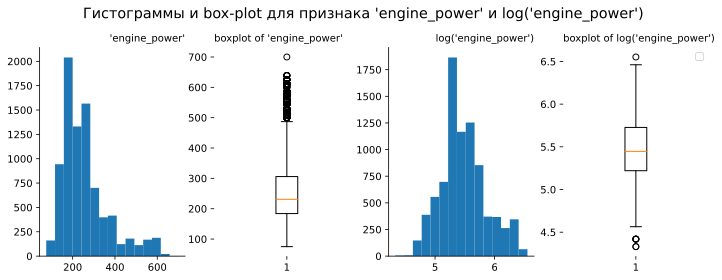

In [52]:
plot_column_info_log(data, 'engine_power')

In [53]:
# Выносим в блок предобработки

# Возьмем логарифм от целевого признака
data.loc[:, 'engine_power_log'] = np.log(data['engine_power'] + 1)

Все хорошо. Оставляем признак как есть.

Признак **'fuel_type'**

In [54]:
column_info(data, 'fuel_type')

Проведем анализ для переменной fuel_type
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 4


,fuel_type
бензин,6018
дизель,2315
гибрид,14
электро,6


Все хорошо. Оставляем признак как есть.

Признак **'mileage'**

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 59246.0, 75-й перцентиль: 167084.0, IQR: 107838.0,
Границы значений: [1, 1000000],
Границы выбросов: [-102511.0, 328841.0].
Есть выбросы.
Количество выбросов: 161


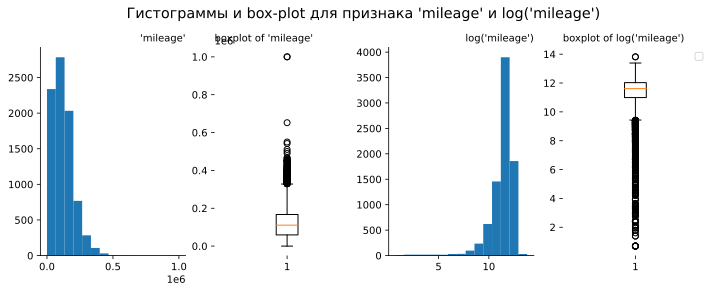

In [55]:
plot_column_info_log(data, 'mileage')

In [56]:
# Выносим в блок предобработки

# Добавим новый признак - возьмем логарифм от признака
data.loc[:, 'mileage_log'] = np.log(data['mileage'] + 1)

Все хорошо. Оставляем признак как есть.

Признак **'model_date'**

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 2007.0, 75-й перцентиль: 2014.0, IQR: 7.0,
Границы значений: [1971, 2019],
Границы выбросов: [1996.5, 2024.5].
Есть выбросы.
Количество выбросов: 191


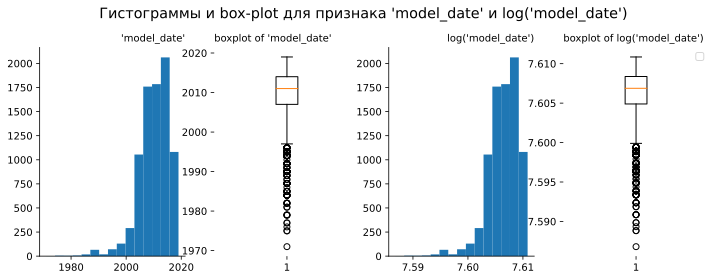

In [57]:
plot_column_info_log(data, 'model_date')

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 5.0, 75-й перцентиль: 12.0, IQR: 7.0,
Границы значений: [0, 48],
Границы выбросов: [-5.5, 22.5].
Есть выбросы.
Количество выбросов: 191


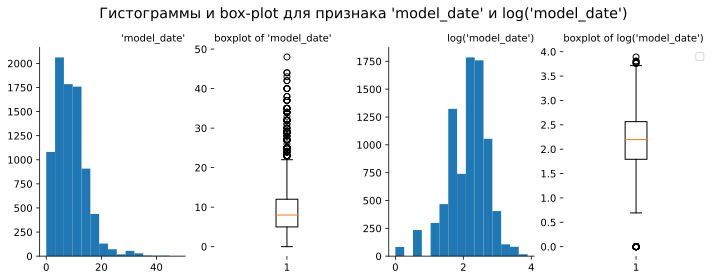

In [58]:
# Если немного преобразовать признак, то гистограмма будет выглядеть лучше
plot_column_info_log(pd.DataFrame(2019 - data['model_date']), 'model_date')

In [59]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'model_date_log'] = np.log(2019 - data['model_date'] + 1)

# Добавим возраст можели
data.loc[:, 'model_age'] = 2021 - data['model_date']

Все хорошо. Оставляем признак как есть.

Признак **'model_info'**

In [60]:
column_info(data, 'model_info')

Проведем анализ для переменной model_info
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 72
Уникальных значений: 122


,model_info
5ER,776
3ER,578
X5,501
E_KLASSE,490
A6,433
A4,297
S_KLASSE,282
7ER,276
C_KLASSE,274
X6,269


In [61]:
# посмотрим, есть ли проблемы со значениями
data['model_info'].unique()

array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
       'GL_KLASSE', 'A6', '1ER', 'X5', 'X3', 'S_KLASSE',
       'S_CLASS_MAYBACH', 'G_KLASSE', 'E_KLASSE', 'X7', 'Q5', 'A3',
       'B_KLASSE', '4', 'CLS_KLASSE_AMG', 'RS3', 'X6', 'C_KLASSE', 'X1',
       'S8', 'Q3', 'X6_M', '7ER', 'GLS_KLASSE', 'A7', 'GLC_KLASSE', 'TT',
       'Q8', 'M3', 'M4', 'C_KLASSE_AMG', 'X4', 'G_KLASSE_AMG', 'VITO',
       'M_KLASSE', 'CLA_KLASSE', 'TTS', 'GLK_KLASSE', 'SLK_KLASSE_AMG',
       'CLS_KLASSE', 'R_KLASSE', 'S_KLASSE_AMG', 'VIANO', 'GLE_KLASSE',
       'S5', 'AMG_GT', 'A8', 'M_KLASSE_AMG', 'A_KLASSE', 'M5', 'X5_M',
       'GLE_KLASSE_COUPE_AMG', 'ALLROAD', 'GLE_KLASSE_COUPE',
       'E_KLASSE_AMG', 'GLA_CLASS', 'SLS_AMG', 'AMG_GLC_COUPE',
       'V_KLASSE', 'GLE_KLASSE_AMG', 'X2', 'A4_ALLROAD', 'CL_KLASSE',
       'SLK_KLASSE', 'CLA_KLASSE_AMG', 'RS5', 'X_KLASSE', 'W123', 'A1',
       'S6', 'M6', 'M1', '2ER', '8ER', 'RS6', 'SL_KLASSE_AMG', 'S7', 'M2',
       'CL_KLASSE_AMG', 'Z4', 'X

Есть значение 'None'

In [62]:
data.query('model_info == "None"')

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,name,number_of_doors,production_date,sell_id,vehicle_configuration,vehicle_transmission,owners,pts,drive_type,wheel,price,sample,owners_isnan,color_is_popular,engine_power_log,mileage_log,model_date_log,model_age
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0,510,бензин,41000,2014,None,63 AMG S 4.0 AT (510 л.с.),4,2017,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,Дубликат,задний,Левый,3700000.0,1,0,2,6.23637,10.621352,1.791759,7


In [63]:
# Вынесем в блок предобработки

# model_info == None для одного значения, заполним его тем же значением, что и для других записей с тем же наименованием
index = data.query('model_info == "None"').index
name = data.query('model_info == "None"')['name'].values[0]

data.loc[index, 'model_info'] = data.query(f'name == "{name}"')['model_info'].mode()[0]

Все хорошо. Оставляем признак как есть.

Признак **'name'**

In [64]:
column_info(data, 'name')

Проведем анализ для переменной name
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 202
Уникальных значений: 976


,name
35i 3.0 AT (306 л.с.) 4WD,151
2.0 AMT (211 л.с.) 4WD,145
200 2.0 AT (184 л.с.),137
30d 3.0d AT (249 л.с.) 4WD,109
400 3.0 AT (333 л.с.) 4WD,97
520i 2.0 AT (184 л.с.),86
2.0 CVT (180 л.с.),81
2.0 AMT (249 л.с.) 4WD,80
350 d 3.0d AT (249 л.с.) 4WD,80
320i xDrive 2.0 AT (184 л.с.) 4WD,77


In [65]:
def clear_name(text: str) -> str:
    patterns = [        
        'AMT', 'AT', 'MT', 'CVT', 'CDI', 
        '4WD', 
        '\(\d+ л.с.\)', '\(\d+ кВт\)',
        '\d\.\d ', '\d\.\dd ', '\d\.\dhyb ', '\d\.\di ', '\d\.\dis ', '\d\.\dsi ', '\d\.\dsd ',
        '\d+ ', '\d+ d ', '\d+Li ', '\d+Ld ', '\d+xi ', '\d+xd ', '\d+d ', '\d+i ',
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, str(text))
        for match in matches:
            text = text.replace(match, '')
    return text.strip().replace('длинный', 'Long') 

In [66]:
data['name'].apply(clear_name).unique()

array(['', 'xDrive', '4x', 'AMG', 'BlueTEC Long', 'BlueTEC', 'TFSI',
       'Competition Package', 'M', 'd', 'BlueTEC L', 'Long', '9G-TRONIC',
       'AMG Long', 'L', 'S', 'Competition', 'Kompressor', 'MxDrive', 'GT',
       'd Long', 'S-tronic', 'd экстра Long', '4MIC', 'ActiveHybrid',
       'BlueEfficiency', '8tiptronic', 'BlueEFFICIENCY', 'AMG S', 'ultra',
       'All-Terrain d', 'Electro', '35is', '5G-Tronic', 'd компактный',
       '8V', '7S-tronic', 'Brabus', 'sDrive', 'BlueTEC BlueEFFICIENCY',
       'clean diesel', '5-speed', 'V', 'Vplus', 'C', 'AMG Edition',
       'HYBRID', 'TDI', 'tiptronic', 'S Electro', '40e', '16V', '94Ah',
       'Pullman', 'Tiptronic', 'Competition Pack', 'R', 'e', '5G-TRONIC'],
      dtype=object)

In [67]:
# Вынесем в блок предобработки

# Добавим несколько признаков, которые соответствуют появлению ключевых значений в признаке 'name'
patterns = ['xDrive', 'AMG', 'Long', 'BlueTEC']
for pattern in patterns:
    data.loc[:, f'name_{pattern}'] = data['name'].apply(lambda text: 1 if len(re.findall(pattern, str(text).replace('длинный', 'Long'))) else 0)


In [68]:
# Выносим в блок предобработки
del_cols.append('name')

Признак **'number_of_doors'**

In [69]:
column_info(data, 'number_of_doors')

Проведем анализ для переменной number_of_doors
Тип данных:  int64
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,number_of_doors
5,3854
4,3636
2,802
3,61


Все хорошо. Оставляем признак как есть.

Признак **'production_date'**

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 2009.0, 75-й перцентиль: 2016.0, IQR: 7.0,
Границы значений: [1982, 2020],
Границы выбросов: [1998.5, 2026.5].
Есть выбросы.
Количество выбросов: 144


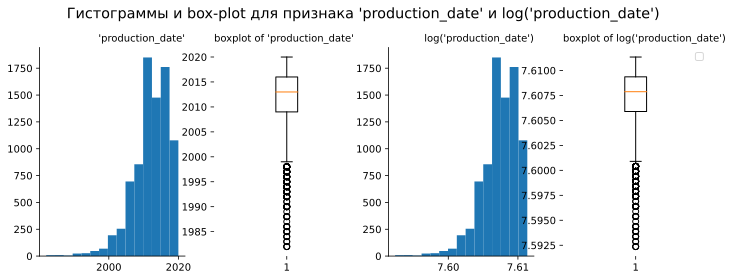

In [70]:
plot_column_info_log(data, 'production_date')

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 4.0, 75-й перцентиль: 11.0, IQR: 7.0,
Границы значений: [0, 38],
Границы выбросов: [-6.5, 21.5].
Есть выбросы.
Количество выбросов: 144


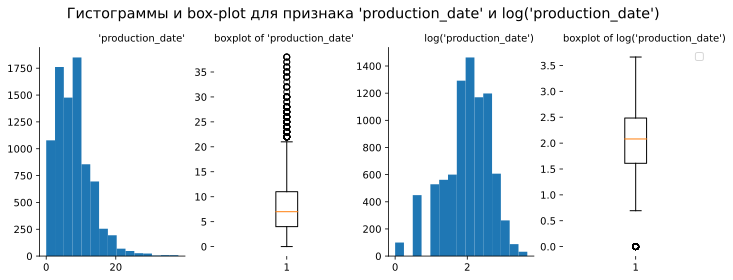

In [71]:
# Если немного преобразовать признак, то гистограмма будет выглядеть лучше
plot_column_info_log(pd.DataFrame(2020 - data['production_date']), 'production_date')

In [72]:
# Выносим в блок предобработки

# Возьмем логарифм от признака
data.loc[:, 'production_date_log'] = np.log(2020 - data['production_date'] + 1)

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 1.0, 75-й перцентиль: 3.0, IQR: 2.0,
Границы значений: [0, 18],
Границы выбросов: [-2.0, 6.0].
Есть выбросы.
Количество выбросов: 64


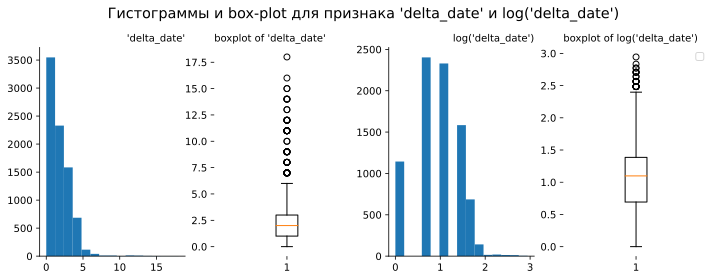

In [73]:
# посмотрим на разницу между production_date и model_date
plot_column_info_log(pd.DataFrame(data['production_date'] - data['model_date'], columns=['delta_date']), 'delta_date')

In [74]:
# Выносим в блок предобработки

# Добавим признак - разницу между production_date и model_date
data.loc[:, 'delta_date'] = data['production_date'] - data['model_date']

# Возьмем логарифм от признака
data.loc[:, 'delta_date_log'] = np.log(data['production_date'] - data['model_date'] + 1)

Всего значений: 8353
Пустых значений: 0
25-й перцентиль: 8909.09090909091, 75-й перцентиль: 17000.0, IQR: 8090.90909090909,
Границы значений: [0.3333333333333333, 76923.0],
Границы выбросов: [-3227.272727272726, 29136.363636363636].
Есть выбросы.
Количество выбросов: 163


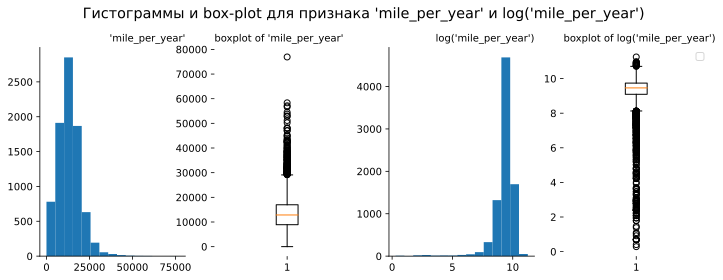

In [75]:
# Посмотрим на количество пройденных миль в год
dt = pd.DataFrame(data['mileage'] / (2021 - data['production_date']), columns=['mile_per_year'])
plot_column_info_log(dt, 'mile_per_year')

In [76]:
# Выносим в блок предобработки

# Добавим признак - количество пройденных миль в год
data.loc[:, 'mile_per_year'] = data['mileage'] / (2021 - data['production_date'])

# Возьмем логарифм от признака
data.loc[:, 'mile_per_year_log'] = np.log(data['mileage'] / (2021 - data['production_date']) + 1)

Признак **'sell_id'** - пропускаем, так как он будет обрабатываться нейросетью

Признак **'vehicle_configuration'**

In [77]:
def clear_vehicle_configuration(text: str) -> str:
    patterns = [        
        'AUTOMATIC', 'ROBOT', 'MECHANICAL', 'VARIATOR',  
        ' \d\.\d', 
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, str(text))
        for match in matches:
            text = text.replace(match, '')
    return text.strip()

In [78]:
data['vehicle_configuration'].apply(clear_vehicle_configuration).unique()

array(['WAGON_5_DOORS', 'COUPE', 'SEDAN', 'ALLROAD_5_DOORS', 'ROADSTER',
       'LIFTBACK', 'HATCHBACK_3_DOORS', 'HATCHBACK_5_DOORS',
       'COUPE_HARDTOP', 'ALLROAD_3_DOORS', 'MINIVAN', 'CABRIO',
       'PICKUP_TWO', 'ALLROAD_OPEN', 'COMPACTVAN', 'SEDAN_2_DOORS',
       'LIMOUSINE'], dtype=object)

In [79]:
data['body_type'].unique()

array(['универсал', 'купе', 'седан', 'внедорожник', 'родстер', 'лифтбек',
       'хэтчбек', 'купе-хардтоп', 'минивэн', 'кабриолет', 'пикап',
       'компактвэн', 'лимузин'], dtype=object)

Вся информация из признака vehicle_configuration повторяется в других колонках. Можно убрать признак.

In [80]:
# Выносим в блок предобработки
del_cols.append('vehicle_configuration')

Признак **'vehicle_transmission'**

In [81]:
column_info(data, 'vehicle_transmission')

Проведем анализ для переменной vehicle_transmission
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,vehicle_transmission
автоматическая,6560
роботизированная,1201
вариатор,406
механическая,186


Все хорошо. Оставляем признак как есть.

Признак **'owners'**

In [82]:
column_info(data, 'owners')

Проведем анализ для переменной owners
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,owners
3 или более,3312
1 владелец,2526
2 владельца,2515


In [83]:
# Вынесем в блок предобработки

# преобразуем значения в численный формат
data.loc[:, 'owners'] = data['owners'].apply(lambda x: int(x[:1]))

Все хорошо. Оставляем признак как есть.

Признак **'pts'**

In [84]:
column_info(data, 'pts')

Проведем анализ для переменной pts
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,pts
Оригинал,7474
Дубликат,879


Все хорошо. Оставляем признак как есть.

Признак **'drive_type'**

In [85]:
column_info(data, 'drive_type')

Проведем анализ для переменной drive_type
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,drive_type
полный,5218
задний,2259
передний,876


Все хорошо. Оставляем признак как есть.

Признак **'wheel'**

In [86]:
column_info(data, 'wheel')

Проведем анализ для переменной wheel
Тип данных:  object
Всего значений: 8353
Пустых значений: 0
Значений, упомянутых более 10 раз: 1
Уникальных значений: 2


,wheel
Левый,8351
Правый,2


Все хорошо. Оставляем признак как есть.

Рассмотрим целевой признак **'price'**

Всего значений: 6682
Пустых значений: 0
25-й перцентиль: 800000.0, 75-й перцентиль: 2299283.25, IQR: 1499283.25,
Границы значений: [301301.0, 23900000.0],
Границы выбросов: [-1448924.875, 4548208.125].
Есть выбросы.
Количество выбросов: 449


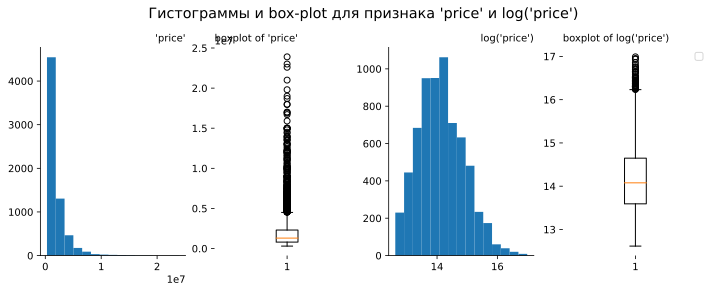

In [87]:
plot_column_info_log(data.query('sample == 1'), 'price')

In [88]:
# Выносим в блок предобработки

# Возьмем логарифм от целевого признака
data.loc[:, 'price_log'] = np.log(data['price'] + 1)

Все хорошо. Оставляем признак как есть.

In [89]:
data.sample(4)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_date,model_info,name,number_of_doors,production_date,sell_id,vehicle_configuration,vehicle_transmission,owners,pts,drive_type,wheel,price,sample,owners_isnan,color_is_popular,engine_power_log,mileage_log,model_date_log,model_age,name_xDrive,name_AMG,name_Long,name_BlueTEC,production_date_log,delta_date,delta_date_log,mile_per_year,mile_per_year_log,price_log
8214,лифтбек,AUDI,чёрный,Автомобиль без проблем по технической и юридич...,3.0,310,бензин,115000,2010,A7,3.0 AMT (310 л.с.) 4WD,5,2013,1099250672,LIFTBACK ROBOT 3.0,роботизированная,2,Оригинал,полный,Левый,1690000.0,1,0,4,5.739793,11.652696,2.302585,11,0,0,0,0,2.079442,3,1.386294,14375.000000,9.573315,14.340240
5946,внедорожник,MERCEDES,синий,[Smart]\n\n\nАвтомобиль соответствует Программ...,4.0,422,бензин,6643,2018,G_KLASSE,500 4.0 AT (422 л.с.) 4WD,5,2019,1099129186,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1,Оригинал,полный,Левый,13777000.0,1,0,2,6.047372,8.801469,0.693147,3,0,0,0,0,0.693147,1,0.693147,3321.500000,8.108473,16.438511
3113,седан,BMW,серебристый,Отдельно поставил:\n- EDC + активные стабилиза...,3.0,249,дизель,4900,2016,5ER,530d xDrive 3.0d AT (249 л.с.) 4WD,4,2018,1098934908,SEDAN AUTOMATIC 3.0,автоматическая,2,Оригинал,полный,Левый,4190000.0,1,0,1,5.521461,8.497195,1.386294,5,1,0,0,0,1.098612,2,1.098612,1633.333333,7.398990,15.248212
8041,внедорожник,MERCEDES,белый,РОЛЬФ - Официальный дилер и Лучший дилер Росси...,2.0,245,дизель,18,2018,GLE_KLASSE,300 d 2.0d AT (245 л.с.) 4WD,5,2020,1100230194,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1,Оригинал,полный,Левый,5670000.0,1,0,3,5.505332,2.944439,0.693147,3,0,0,0,0,0.000000,2,1.098612,18.000000,2.944439,15.550700


In [90]:
# Выведем общую информацию по датасету
data_full_info(data, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,body_type,object,8353,0,13,NaN,NaN,NaN,NaN
1,brand,object,8353,0,3,NaN,NaN,NaN,NaN
2,color,object,8353,0,16,NaN,NaN,NaN,NaN
3,description,object,8353,0,7654,NaN,NaN,NaN,NaN
4,engine_displacement,float64,8353,0,48,0,2.77745,6.6,2.8
5,engine_power,int64,8353,0,154,75,255.56,700,231
6,fuel_type,object,8353,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,8353,0,3507,1,120363,1e+06,110384
8,model_date,int64,8353,0,43,1971,2010.1,2019,2011
9,model_info,object,8353,0,121,NaN,NaN,NaN,NaN


In [91]:
cat_cols = [
    'body_type', 'brand', 'color', 'fuel_type', 'model_info', 
    'vehicle_transmission', 'drive_type'
]
bin_cols = [
    'name_xDrive', 'name_AMG', 'name_Long', 'name_BlueTEC',
    'pts', 'wheel', 'owners_isnan'
]
num_cols = [
    'engine_displacement', 'engine_power', 'mileage', 'mileage_log', 'model_date', 
    'model_date_log', 'number_of_doors', 'production_date', 'production_date_log',
    'owners', 'color_is_popular', 'delta_date', 'delta_date_log', 'engine_power_log',
    'mile_per_year_log', 'mile_per_year', 'model_age'
]
del_cols = [
    'name', 'vehicle_configuration'
]
info_cols = [
    'description', 'sell_id'
]
target_cols = [
    'price', 'price_log'
]

# Суммарное количество признаков должно быть на одно меньше, чем в тамблице (не учитываем sample)
data.shape[1] - len(cat_cols + bin_cols + num_cols + del_cols + info_cols + target_cols) - 1

0

In [92]:
# Выведем информацию после изменений
data_full_info(data[cat_cols + bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,body_type,object,8353,0,13,универсал,купе,купе
1,brand,object,8353,0,3,MERCEDES,BMW,BMW
2,color,object,8353,0,16,чёрный,белый,пурпурный
3,fuel_type,object,8353,0,4,бензин,дизель,бензин
4,model_info,object,8353,0,121,W124,6ER,3ER
5,vehicle_transmission,object,8353,0,4,автоматическая,автоматическая,автоматическая
6,drive_type,object,8353,0,3,задний,полный,полный
7,name_xDrive,int64,8353,0,2,0,1,0
8,name_AMG,int64,8353,0,2,0,0,0
9,name_Long,int64,8353,0,2,0,0,0


In [93]:
# Выведем информацию после изменений
data_full_info(data[num_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,engine_displacement,float64,8353,0,48,3,3,2.5
1,engine_power,int64,8353,0,154,220,313,218
2,mileage,int64,8353,0,3507,350000,15000,166600
3,mileage_log,float64,8353,0,3507,12.7657,9.61587,12.0234
4,model_date,int64,8353,0,43,1984,2011,2005
5,model_date_log,float64,8353,0,43,3.58352,2.19722,2.70805
6,number_of_doors,int64,8353,0,4,5,2,2
7,production_date,int64,8353,0,39,1991,2013,2008
8,production_date_log,float64,8353,0,39,3.4012,2.07944,2.56495
9,owners,int64,8353,0,3,3,1,3


Объединим всю предобработку признаков в единую функцию

In [94]:
# Создадим в блок предобработки Данных
def clear_and_prepare_data(data_in: pd.DataFrame) -> pd.DataFrame:
    data = data_in.copy()
    
    # 1. Почистим данные, уберем пропуски.   
    # Заполним пропуски в поле owners самым распространенным значением
    data = replace_nan(data, 'owners', 'mode')
    # Доля пустых значений в поле ownership очень большая, мы не можем полагаться на значения данного поля - удалим
    data = data.drop(['ownership'], axis=1)
    
    # 2. Обработаем остальные признаки и создадим новые
    # В body_type оставим только внедорожник, седан, лифтбек и т.д. без доп.информации
    data.loc[:, 'body_type'] = data['body_type'].apply(lambda x: x.split(' ')[0].lower())

    # Добавим новый признак - степень популятности цвета    
    data.loc[:, 'color_is_popular'] = data['color'].apply(color_is_popular)
    
    # вынесем существенную информацию и преобразуем значения в численный формат
    data.loc[:, 'engine_displacement'] = data['engine_displacement'].apply(search_engine_displacement)
    
    # Поле engine_power представлено в виде "306 N12", нам надо только число Л.С.
    data.loc[:, 'engine_power'] = data['engine_power'].apply(lambda x: int(x.split(' ')[0]))    
    # Возьмем логарифм от признака engine_power
    data.loc[:, 'engine_power_log'] = np.log(data['engine_power'] + 1)
    
    # Добавим новый признак - возьмем логарифм от признака mileage
    data.loc[:, 'mileage_log'] = np.log(data['mileage'] + 1)
    
    # Добавим новый признак - возьмем логарифм от возраста модели (по model_date)
    data.loc[:, 'model_date_log'] = np.log(2020 - data['model_date'] + 1)
    
    # model_info == None для одного значения, заполним его тем же значением, что и для других записей с тем же наименованием
    index = data.query('model_info == "None"').index
    name = data.query('model_info == "None"')['name'].values[0]
    data.loc[index, 'model_info'] = data.query(f'name == "{name}"')['model_info'].mode()[0]
    
    # Добавим несколько признаков, которые соответствуют появлению ключевых значений в признаке 'name'
    patterns = ['xDrive', 'AMG', 'Long', 'BlueTEC']
    for pattern in patterns:
        data.loc[:, f'name_{pattern}'] = data['name'].apply(lambda text: 1 if len(re.findall(pattern, str(text).replace('длинный', 'Long'))) else 0)
    
    # Добавим новый признак - возьмем логарифм от возраста автомобиля (по model_date)
    data.loc[:, 'production_date_log'] = np.log(2020 - data['production_date'] + 1)
    
    # Добавим признак - разницу между production_date и model_date
    data.loc[:, 'delta_date'] = data['production_date'] - data['model_date']
    # Возьмем логарифм от признака
    data.loc[:, 'delta_date_log'] = np.log(data['production_date'] - data['model_date'] + 1)
    
    #
    data.loc[:, 'model_age'] = (2020 - data['model_date'] + 1)
    
    # Добавим признак - количество пройденных миль в год
    data.loc[:, 'mile_per_year'] = data['mileage'] / (2020 - data['production_date'] + 1)
    # Возьмем логарифм от признака
    data.loc[:, 'mile_per_year_log'] = np.log(data['mileage'] / (2020 - data['production_date'] + 1))
    
    # преобразуем значения в численный формат
    data.loc[:, 'owners'] = data['owners'].apply(lambda x: int(x[:1]))
    
    # Возьмем логарифм от целевого признака
    data.loc[:, 'price_log'] = np.log(data['price'] + 1)
    
    return data

Проверим, что были учтены все изменения признаков

In [95]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

# Обработаем признаки - почистим данные и добавим новые признаки
data = clear_and_prepare_data(data)

В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners самым распространенным значением  3 или более


In [96]:
# Выведем информацию после изменений
data_full_info(data[cat_cols + bin_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,body_type,object,8353,0,13,универсал,купе,купе
1,brand,object,8353,0,3,MERCEDES,BMW,BMW
2,color,object,8353,0,16,чёрный,белый,пурпурный
3,fuel_type,object,8353,0,4,бензин,дизель,бензин
4,model_info,object,8353,0,121,W124,6ER,3ER
5,vehicle_transmission,object,8353,0,4,автоматическая,автоматическая,автоматическая
6,drive_type,object,8353,0,3,задний,полный,полный
7,name_xDrive,int64,8353,0,2,0,1,0
8,name_AMG,int64,8353,0,2,0,0,0
9,name_Long,int64,8353,0,2,0,0,0


In [97]:
# Выведем информацию после изменений
data_full_info(data[num_cols], full=False, short=False)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,в первой строке,во второй строке,в третьей строке
0,engine_displacement,float64,8353,0,48,3,3,2.5
1,engine_power,int64,8353,0,154,220,313,218
2,mileage,int64,8353,0,3507,350000,15000,166600
3,mileage_log,float64,8353,0,3507,12.7657,9.61587,12.0234
4,model_date,int64,8353,0,43,1984,2011,2005
5,model_date_log,float64,8353,0,43,3.61092,2.30259,2.77259
6,number_of_doors,int64,8353,0,4,5,2,2
7,production_date,int64,8353,0,39,1991,2013,2008
8,production_date_log,float64,8353,0,39,3.4012,2.07944,2.56495
9,owners,int64,8353,0,3,3,1,3


## Оценка корреляций

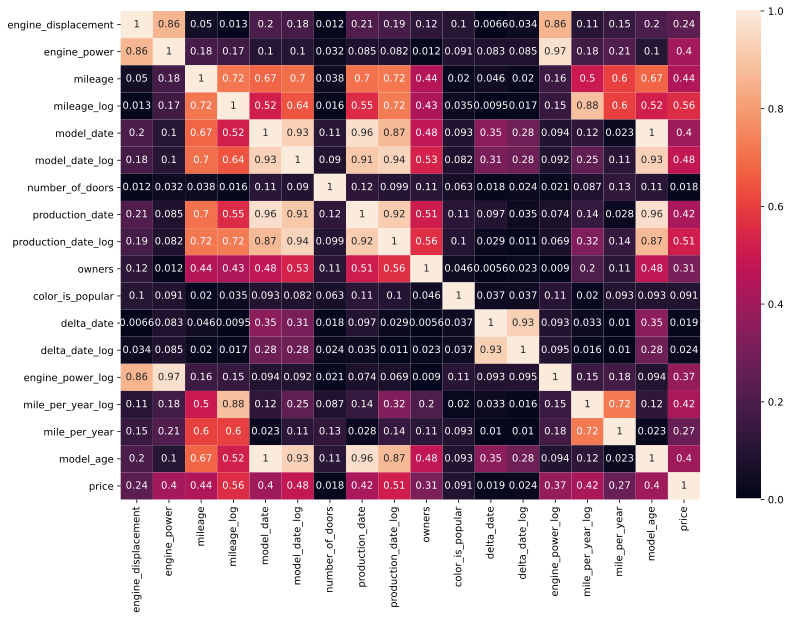

In [98]:
# Оценим корреляцию Пирсона для непрерывных переменных 
plt.figure(figsize = (13,9))
data_corr = data[num_cols + ['price']].corr().abs()
sns.heatmap(data_corr, vmin=0, vmax=1, annot=True)

**Оценки по матрице корелляции**

1. Можно заметить большую корреляцию между парами признаков engine_displacement и engine_displacement_log (и им подобные) - что логично, один из признаков уберем. Будем исходить из того, какой лучше коррелирует с целевым признаком.
2. engine_power и engine_displacement хорошо коррелируют, это объяснимо, ведь чем больше объем двигателя, тем больше его мощьность, если рассматривать двигатели примерно одно класса (год, наличие турбин и т.д.). Пока оставим все как есть
3. Сильно скоррелированы model_date и production_date - что также логично. Уберем один признак - model_date
4. Также можно заметить, что mileage, owners и model_date тоже хорошо скоррелированны, чем старше авто, тем веше пробег и количество владельцев. Оставляем как есть.


In [99]:
# Выносим в блок предобработки

# 1. mileage, production_date, model_date, engine_power_log, delta_date
for col in ['mileage', 'production_date', 'model_date', 'engine_power_log', 'delta_date']:
    #Удаляем лишний признак 
    del_cols.append(col)
    num_cols.remove(col)

# 2 и 3 model_date_log, mile_per_year_log
for col in ['model_date_log', 'mile_per_year_log']:
    #Удаляем лишний признак 
    del_cols.append(col)
    num_cols.remove(col)

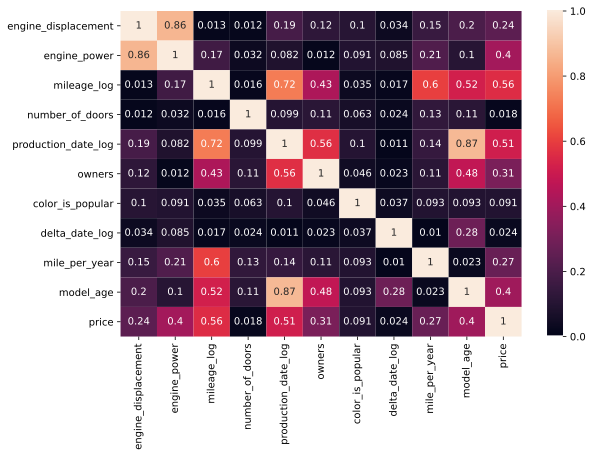

In [100]:
# Оценим корреляцию Пирсона для непрерывных переменных 
plt.figure(figsize = (9,6))
data_corr = data[num_cols + ['price']].corr().abs()
sns.heatmap(data_corr, vmin=0, vmax=1, annot=True)

In [101]:
pd.DataFrame(data_corr['price'].sort_values(ascending=False))

,price
price,1.000000
mileage_log,0.557616
production_date_log,0.513643
engine_power,0.404552
model_age,0.397267
owners,0.309139
mile_per_year,0.269509
engine_displacement,0.240498
color_is_popular,0.090676
delta_date_log,0.024409


**Выводы по матрице корреляций**

C целевым признаком выше всего скоррелированы (по убыванию):

 - mileage_log (пробег)
 - production_date_log (дата производства)
 - engine_power (мощность авто л.с.)
 - model_age (возраст модели)
 - owners (кол-во владельцев)
 - mile_per_year (количество пройденных миль за год)
 - engine_displacement (объем двигателя)
 - color_is_popular (популярный цвет или нет)
 - delta_date_log (разница между датой модели и датой выпуска самого авто)
 - number_of_doors (количество дверей)

в датасете присутствует объяснимая сильная корреляция некоторых признаков. Часть признаков мы убрали.

## Посмотрим на значимость колличественных переменных

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

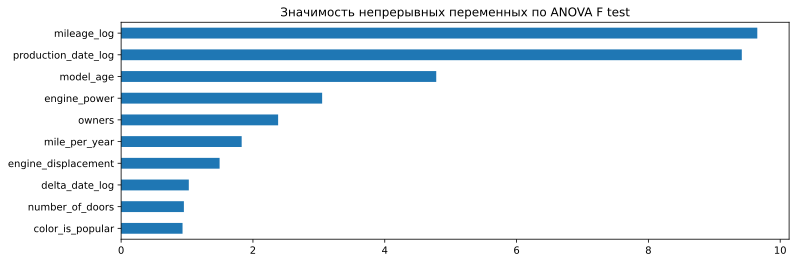

In [102]:
df = data.query('sample == 1')
imp_num = pd.Series(f_classif(df[num_cols], df['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

**Выводы:**

 - Самые значимые признаки mileage_log и production_date_log
 - Потом идут признаки по убыванию значимости: model_age, engine_power, owners, mile_per_year и engine_displacement
 - Последние по значимости признаки - delta_date_log, number_of_doors и color_is_popular

## Посмотрим на значимость категориальных и бинарных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [103]:
nom_cols = cat_cols + bin_cols
delete_cols = []

for col in nom_cols:
    if not get_stat_dif(data.query('sample == 1'), col, 'price_log'):
        delete_cols.append(col)
        
print('Признаки на удаление: ', delete_cols)

Найдены статистически значимые различия для признака body_type
Найдены статистически значимые различия для признака brand
Найдены статистически значимые различия для признака color
Найдены статистически значимые различия для признака fuel_type
Найдены статистически значимые различия для признака model_info
Найдены статистически значимые различия для признака vehicle_transmission
Найдены статистически значимые различия для признака drive_type
Найдены статистически значимые различия для признака name_xDrive
Найдены статистически значимые различия для признака name_AMG
Найдены статистически значимые различия для признака name_Long
Найдены статистически значимые различия для признака name_BlueTEC
Найдены статистически значимые различия для признака pts
Признаки на удаление:  ['wheel', 'owners_isnan']


In [104]:
# Уберем признаки wheel, owners_isnan
for col in ['wheel', 'owners_isnan']:
    #Удаляем лишний признак 
    del_cols.append(col)
    bin_cols.remove(col)

**Выводы**

 - Есть два признака - 'wheel' и 'owners_isnan', по которым отсутствуют статистически значимые различия
 - По остальным признакам такие различия присутствуют.


# 6. Data Preprocessing

Перед обучением регрессии необходимо сделать две вещи:

 - Стандартизировать числовые признаки
 - Применить Label Encoding подход к категориальным признакам
 - Сделать разбиение на тестовую и валидационную выборки

In [105]:
def get_columns():
    cat_cols = [
        'body_type', 'brand', 'color', 'fuel_type', 'model_info', 
        'vehicle_transmission', 'drive_type'
    ]
    bin_cols = [
        'name_xDrive', 'name_AMG', 'name_Long', 'name_BlueTEC', 'pts'
    ]
    num_cols = [
        'engine_power', 'mileage_log', 'number_of_doors', 'production_date_log',
        'owners', 'color_is_popular', 'delta_date_log', 'mile_per_year', 'engine_displacement', 'model_age'
    ]
    del_cols = [
        'name', 'vehicle_configuration', 'mileage', 'production_date',
        'model_date', 'engine_power_log', 'delta_date', 
        'model_date_log', 'wheel', 'owners_isnan', 'mile_per_year_log'
    ]
    info_cols = ['description', 'sell_id']
    target_cols = ['price', 'price_log']
    
    return info_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols


In [106]:
def prepare_data_before_split(data_in: pd.DataFrame, column_target: str):
    '''includes several functions to pre-process the predictor data.'''
    
    data = data_in.copy()
    info_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols = get_columns()
    
    # Суммарное количество признаков должно быть на одно меньше, чем в тамблице (не учитываем sample)
    columns_check =  len(cat_cols + bin_cols + num_cols + del_cols + info_cols + target_cols) + 1
    print(f'Суммарное количество признаков {columns_check} должно совпадать с размерностью тамблицы {data.shape[1]}')
    
    ############## Numerical Features ##############
    # Стандартизация числовых переменных  
    #scaler = MinMaxScaler()
    scaler = RobustScaler() # применим именно эту стандартизацию,тк она устойчива к выбросам
    for column in num_cols:
        data[column] = scaler.fit_transform(data[[column]])[:,0]
        
    # ############## Categorical Features ############## 
    # Применим подход Label Encoding для категориальных признаков
    for column in cat_cols:
        data[column] = data[column].astype('category').cat.codes
    # сделаем тоже самое для бинарных признаков, 
    for column in bin_cols:
        data[column] = data[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    data = pd.get_dummies(data, columns=cat_cols, dummy_na=False)

    # ############## Split train and submition data ############## 
    X = data.query('sample == 1').drop(columns=info_cols + del_cols + target_cols + ['sample'])
    X_sub = data.query('sample == 0').drop(columns=info_cols + del_cols + target_cols + ['sample'])
    y = data.query('sample == 1')[column_target]
    
    return X, X_sub, y

In [107]:
# Запускаем и проверяем, что получилось
X, X_sub, y = prepare_data_before_split(data, 'price')
X.sample(10)

Суммарное количество признаков 38 должно совпадать с размерностью тамблицы 38


,engine_displacement,engine_power,number_of_doors,owners,pts,color_is_popular,mileage_log,name_xDrive,name_AMG,name_Long,name_BlueTEC,production_date_log,delta_date_log,model_age,mile_per_year,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,body_type_8,body_type_9,body_type_10,body_type_11,body_type_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,drive_type_0,drive_type_1,drive_type_2
4565,0.2,0.614754,0.0,0.5,0,-0.5,0.119935,1,0,0,0,0.000000,0.000000,0.000000,0.342095,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6061,0.2,0.565574,0.0,0.0,1,0.5,0.471638,0,0,0,0,0.254885,-1.584963,0.000000,0.635634,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1794,-0.8,-0.106557,0.0,-0.5,1,-0.5,-0.583684,1,0,0,0,-0.152526,-0.584963,-0.285714,-0.524963,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8097,-0.3,-0.221311,-2.0,0.5,1,-0.5,-0.979053,0,0,0,0,0.463141,-1.584963,0.285714,-1.177100,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Загрузим и подготовим все данные снуля

In [108]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

# Обработаем признаки - почистим данные и добавим новые признаки
data = clear_and_prepare_data(data)

# сделаем предобработку
X, X_sub, y = prepare_data_before_split(data, 'price')

# Разобъем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

В новый признак 'owners_isnan' охраняем информацию, в каком наблюдении указано NaN
Заполним пустые значения признака owners самым распространенным значением  3 или более
Суммарное количество признаков 38 должно совпадать с размерностью тамблицы 38


# 7. Model 2: CatBoostRegressor

In [109]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418738	test: 0.0419445	best: 0.0419445 (0)	total: 54.5ms	remaining: 4m 32s
100:	learn: 0.0130439	test: 0.0126795	best: 0.0126795 (100)	total: 359ms	remaining: 17.4s
200:	learn: 0.0104318	test: 0.0101208	best: 0.0101208 (200)	total: 643ms	remaining: 15.3s
300:	learn: 0.0098428	test: 0.0095939	best: 0.0095939 (300)	total: 912ms	remaining: 14.2s
400:	learn: 0.0094468	test: 0.0092849	best: 0.0092836 (398)	total: 1.18s	remaining: 13.5s
500:	learn: 0.0091039	test: 0.0090583	best: 0.0090577 (499)	total: 1.45s	remaining: 13.1s
600:	learn: 0.0087204	test: 0.0087965	best: 0.0087965 (600)	total: 1.74s	remaining: 12.7s
700:	learn: 0.0084028	test: 0.0085941	best: 0.0085941 (700)	total: 2.01s	remaining: 12.4s
800:	learn: 0.0081384	test: 0.0084558	best: 0.0084546 (799)	total: 2.3s	remaining: 12.1s
900:	learn: 0.0079194	test: 0.0083394	best: 0.0083394 (900)	total: 2.59s	remaining: 11.8s
1000:	learn: 0.0077287	test: 0.0082263	best: 0.0082263 (1000)	total: 2.87

In [110]:
#test_predict_catboost = model.predict(X_test)
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.18%


### Submission

In [111]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# 8. Model 3: Tabular NN

Построим обычную сеть:

In [112]:
X_train.head(5)

,engine_displacement,engine_power,number_of_doors,owners,pts,color_is_popular,mileage_log,name_xDrive,name_AMG,name_Long,name_BlueTEC,production_date_log,delta_date_log,model_age,mile_per_year,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,body_type_8,body_type_9,body_type_10,body_type_11,body_type_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,drive_type_0,drive_type_1,drive_type_2
7320,3.2,2.565574,0.0,-0.5,1,0.0,0.295786,0,0,0,0,0.254885,0.415037,0.428571,0.264848,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8037,-0.8,0.114754,1.0,-0.5,1,-0.5,-1.603192,0,0,0,0,-1.120348,0.000000,-0.714286,-0.726306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4681,0.3,0.196721,0.0,0.5,1,0.5,0.186252,0,0,0,0,0.718025,0.000000,1.000000,-0.485814,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6014,-1.0,-0.385246,0.0,0.5,1,-0.5,1.056264,0,0,0,0,0.639218,-0.584963,0.714286,1.324238,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Simple Dense NN

In [113]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) # tanh sigmoid relu
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dense(512, activation="relu")) #добавили допонительный полносвязный слой
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [114]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               92160     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 617,985
Trainable params: 617,985
Non-trainable params: 0
__________________________________________________

In [115]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

### Коллбэки

Определим коллбэки для нашей будущей модели. В частности добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [116]:
checkpoint = ModelCheckpoint(
    filepath='../working/best_model.hdf5', 
    monitor='val_MAPE', 
    save_best_only=True,
    verbose=0,
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_MAPE', 
    factor=0.5, 
    min_lr=1e-5, 
    patience=10, 
    verbose=1
)
callbacks_list = [checkpoint, earlystop, reduce_lr]

### Fit

In [117]:
history = model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0,
)


Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Restoring model weights from the end of the best epoch.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 00231: early stopping


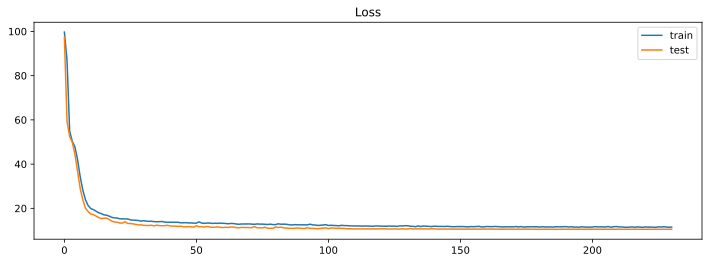

In [118]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [119]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [120]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.51%


 - baseline - Test MAPE: 14.24%
 - предобработанные данные, activation 'relu'     - Test MAPE: 11.07%
 - предобработанные данные, activation 'tanh'     - Test MAPE: 12.07% 
 - предобработанные данные, activation 'sigmoid'  - Test MAPE: 11.35% 
 - +1 Dense Layer, activation 'relu'     - Test MAPE: 10.86%
 - +1 Dense Layer, activation 'tanh'     - Test MAPE: 10.88%
 - +1 Dense Layer, activation 'sigmoid'  - Test MAPE: 10.77%
 - +1 Dense Layer 512, activation 'sigmoid'  - Test MAPE: 10.55%

In [121]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# 9. Blend

In [122]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.45%


In [123]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# 10. Итог первой части

* Построили "наивную"/baseline модель, предсказывающую цену по модели и году выпуска
* Обработали и отнормировали признаки
* Построили первую модель на основе градиентного бустинга с помощью CatBoost
* Построили вторую модель на основе нейронных сетей
* Осуществили ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

**Итоговый сабмит** ансамбля моделей в соревновании получился **11.10315** (31-е место в Leaderboard из 149)

In [124]:
# 